# Interferogram processing for calibration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from skimage.restoration import unwrap_phase
from skimage.io import imread_collection
from skimage.draw import disk
from skimage.transform import resize
%matplotlib ipympl

## Get the data and resize it

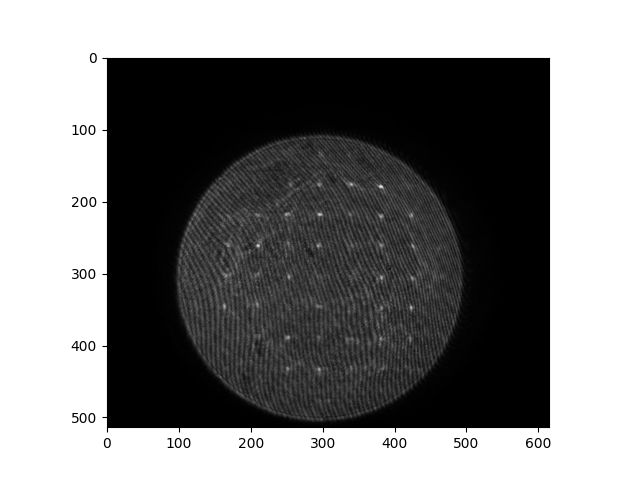

In [2]:
images = imread_collection('data/measurements/*.png')
N = len(images)
ref = images[0].astype(float)

W, H = np.array(ref.shape)

scale_factor = 0.25

resized = np.zeros((N,int(W*scale_factor),int(H*scale_factor)))

for i, image in enumerate(images):
    new_shape = (
        int(image.shape[0] * scale_factor),
        int(image.shape[1] * scale_factor),
    )
    resized[i] = resize(image, new_shape, anti_aliasing=True)
ref = resized[0]


plt.close(0)
plt.figure(0)
plt.imshow(ref,cmap='gray')
plt.show()

## Ideka's method for Phase-Shifting Interferometry (PSI) analysis


The magic sauce

In [3]:
def extract_phase(img, pad_factor = 2, cx = 0, cy = 0, r = 50, AUTOPEAK = True, HANNING =True,  SETUP = False):
    '''------------------------------------------------------------------------------------
    Extract the phase for retarded interferograms relatively to a reference.
    Inputs:
       img (ndarray): the image to extract the phase from.
       pad_factor (int) factor by which to pad the image.
       cx (int): x-coordinate of the center of the frequency peakc of interest.
       cy (int): y-coordinate of the center of the frequency peakc of interest.
       r (int): radius of the disk to extract the phase from.
       AUTOPEAK (bool): if True the center of the frequency peak is automatically detected.
       HANNING (bool: if true, a Haning window is aplied to the image.
       SETUP (bool): if True the function will display the raw, raw + roi, and processed interferograms.    
    Returns:
        phase (ndarray): the phase extracted from the image
    To do:
    TODO: input checks
    TODO: make autopeak use the compleate half of the image and adapt full coordinate conversion
    ------------------------------------------------------------------------------------'''
    H, W = img.shape

    if HANNING:
        win_x = np.hanning(H)
        win_y = np.hanning(W)
        window_2d = np.outer(win_x, win_y)
        img = img * window_2d    


    if SETUP:
        plt.close(0)
        plt.figure(0)
        plt.imshow(img, cmap='gray')
        plt.title("Hanned image")
        plt.show()

    pad_shape = (int(H * pad_factor), int(W * pad_factor))
    padded = np.zeros(pad_shape)
    start_x = (pad_shape[0] - H) // 2
    start_y = (pad_shape[1] - W) // 2
    padded[start_x:start_x + H, start_y:start_y + W] = img    


    F = fftshift(fft2(padded))

    if SETUP:
        plt.close(1)
        plt.figure(1)
        plt.imshow(np.log1p(np.abs(F)), cmap='gray')
        plt.title("FFT Magnitude")
        plt.show()


    mask = np.zeros_like(F)

    if AUTOPEAK:
        cx, cy = np.array(F.shape)//2
        search_area = F[cx-100:cx+100, cy+30:cy+130]  # restrict search to one sideband region (cx+30)

        peak_rel = np.unravel_index(np.argmax(search_area), search_area.shape)
        peak = (peak_rel[0] + cx - 100, peak_rel[1] + cy + 30)  # convert back to full coordinates
        rr, cc = disk(center=peak, radius=r, shape=F.shape)
    else:
        rr, cc = disk((cx, cy), radius=r, shape=F.shape)

    mask[rr, cc] = 1

    if SETUP:
        plt.close(2)
        plt.figure(2)
        plt.imshow(np.log1p(np.abs(F)), cmap='gray')
        plt.contour(mask, colors='r')
        plt.title("FFT Magnitude with Mask Overlay")
        plt.show()

    filtered = ifft2(F * mask)[start_x:start_x+H, start_y:start_y+W]
    phase_map = np.angle(filtered)
    # phase_map = np.angle(F * mask)[start_x:start_x+H, start_y:start_y+W]

    if SETUP:
        plt.close(3)
        plt.figure(3)
        plt.imshow(phase_map, cmap='gray')
        plt.title("Wrapped Phase Map")
        plt.show()

    return phase_map

## Crop the images to avoid contaminating the frequencies and speed up the process

(411, 411)


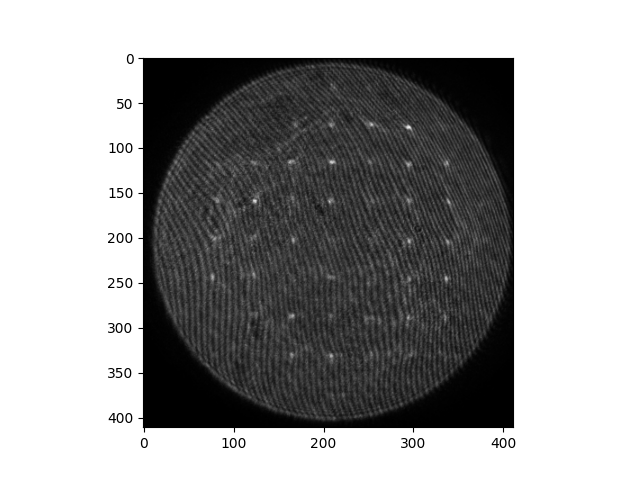

In [4]:
cx, cy = np.array(ref.shape)//2
cx -= -35
cy -= -0
c = 205
crop = ref[cy-c-1:cy+c,cx-c-1:cx+c]

new_width, new_height = np.array(crop.shape)
if new_width != new_height:
       raise ValueError(f"The image should be square. The half sizxe and center offset are not compatible. Found ({new_width:d},{new_height:d})")


print(crop.shape)
plt.close(0)
plt.figure(0)
plt.imshow(crop,cmap='gray')
plt.show()

In [5]:
N = len(resized)
phases = np.zeros(N)
deltas = np.zeros(N)
pad_factor = 2


status = 0
N = 512
status_frac = 10
n = N//status_frac


ref_phase = unwrap_phase(extract_phase(ref[cy-c:cy+c,cx-c:cx+c], pad_factor, r =10, SETUP=False))

old_phase = ref_phase



for i in range(1, N):
    # wrapped = extract_phase(resized[i][cy-c:cy+c,cx-c:cx+c], pad_factor, r =10)

    # delta = unwrap_phase(wrapped) - ref_phase
    # delta_mod = np.mod(delta, 2 * np.pi)
    # delta_mod = delta
    # h, w = delta_mod.shape
    # roi = delta_mod[h//4:3*h//4, w//4:3*w//4]
    # phases[i] = np.mean(roi)


    unwraped = unwrap_phase(extract_phase(resized[i][cy-c:cy+c,cx-c:cx+c], pad_factor, r =10))

    delta = unwraped - old_phase
    old_phase = unwraped

    h, w = delta.shape

    deltas[i] = np.mean(delta[h//4:3*h//4, w//4:3*w//4])%(2*np.pi)
    
    phases[i] = (phases[i-1]+deltas[i])%(2*np.pi)

 

    # if i == 8:
    #     plt.close(2)
    #     plt.figure(2)
    #     plt.imshow(wrapped[h//4:3*h//4, w//4:3*w//4])
    #     # plt.plot(phases[256:511])
    #     plt.grid()
    #     plt.show()
    #     plt.close(3)
    #     plt.figure(3)
    #     plt.imshow(ref_phase[h//4:3*h//4, w//4:3*w//4])
    #     # plt.plot(phases[256:511])
    #     plt.grid()
    #     plt.show()
    #     plt.close(4)
    #     plt.figure(4)
    #     plt.imshow((ref_phase[h//4:3*h//4, w//4:3*w//4]-wrapped[h//4:3*h//4, w//4:3*w//4])%(2*np.pi))
    #     # plt.plot(phases[256:511])
    #     plt.grid()
    #     plt.show()

    # print(np.mean(ref_phase[h//4:3*h//4, w//4:3*w//4]-wrapped[h//4:3*h//4, w//4:3*w//4])%(2*np.pi))
    if i%n == 0 :
        print(f"Processing: {status:d}%")
        status += status_frac


Processing: 0%
Processing: 10%
Processing: 20%
Processing: 30%
Processing: 40%
Processing: 50%
Processing: 60%
Processing: 70%
Processing: 80%
Processing: 90%


1.9166506479939749


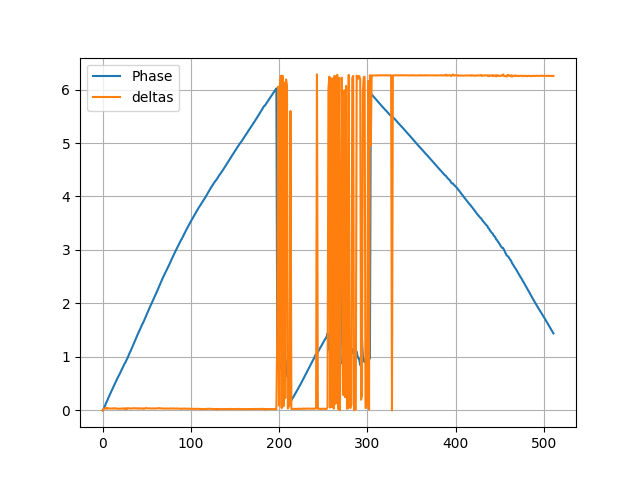

In [6]:
print(np.max(phases%(2*np.pi))/np.pi)

x1 = np.linspace(0,255,256)
# # x2 = np.linspace(256,511,256)
plt.close(0)
plt.figure(0)
plt.plot(phases,label = 'Phase')
plt.plot(deltas, label = 'deltas')
# plt.plot(phases[256:511])
plt.grid()
plt.legend()
plt.show()

256


<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
C:\Users\amd\AppData\Local\Temp\ipykernel_2208\2085591183.py:21: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_ylabel("$\Delta \\varphi$ to $x_0$", fontsize=16)
C:\Users\amd\AppData\Local\Temp\ipykernel_2208\2085591183.py:32: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel("$\Delta \\varphi$ to $x_{n-1}$", fontsize=16)
C:\Users\amd\AppData\Local\Temp\ipykernel_2208\2085591183.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,8))
C:\Users\amd\AppData\Local\Temp\ipykernel

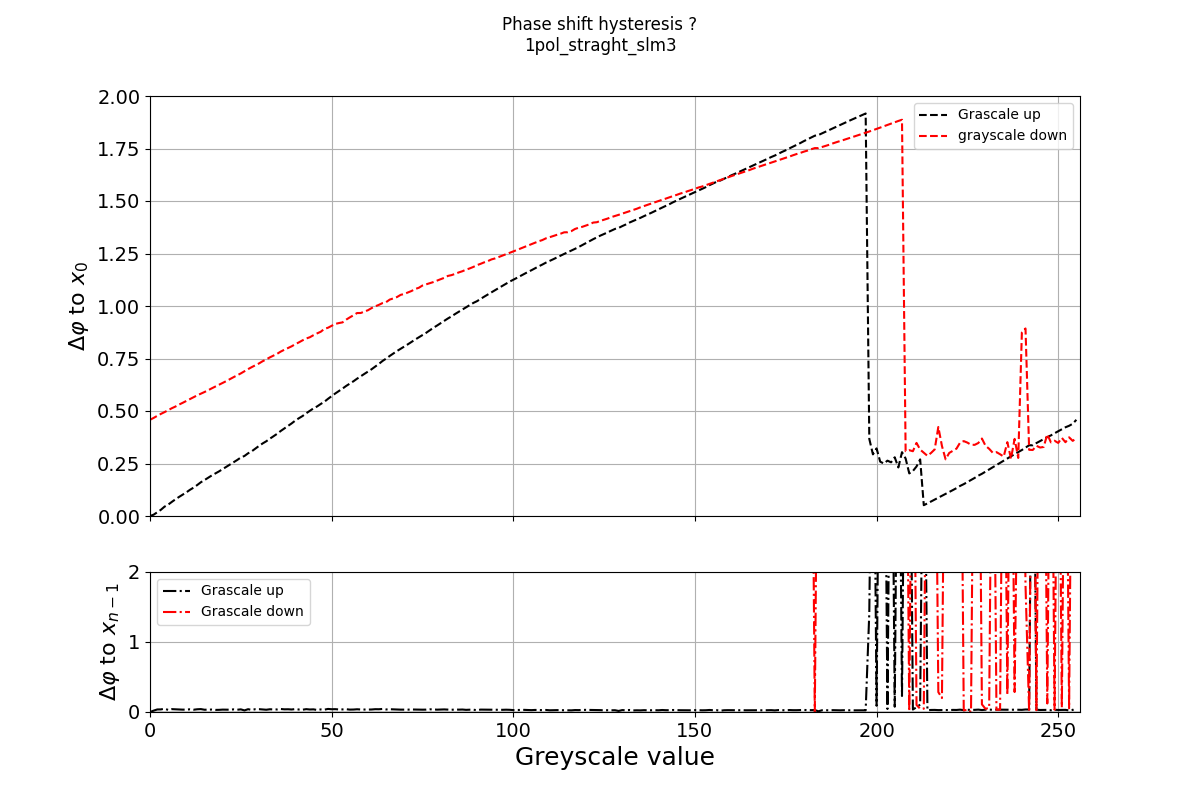

In [105]:
print(len(phases[0:256],))
x1 = np.linspace(0,255,256)


phases_up = phases[0:256]
deltas_up = deltas[0:256]

phases_down = np.flip(phases[256:512])
deltas_down = np.flip(deltas[256:512])



fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.2)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)


ax1.plot(x1,phases_up/np.pi, '--k', label = "Grascale up")         
ax1.plot(x1,phases_down/np.pi, '--r', label = "grayscale down")
ax1.set_ylabel("$\Delta \\varphi$ to $x_0$", fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.tick_params(axis='x', labelbottom=False)
ax1.set_ylim([0,2])
ax1.grid()
ax1.legend()

ax2.plot(x1, deltas_up, '-.k', label = "Grascale up")
ax2.plot(x1, deltas_down, '-.r', label = "Grascale down")

ax2.axhline(0, color='k', linewidth=1)
ax2.set_ylabel("$\Delta \\varphi$ to $x_{n-1}$", fontsize=16)
ax2.set_xlabel("Greyscale value", fontsize=18)
ax2.tick_params(axis='both', labelsize=14)
ax2.set_ylim([0,2])
ax2.set_xlim([0,N//2])
ax2.grid()

plt.legend()

plt.suptitle("Phase shift hysteresis ?\n1pol_straght_slm3")
plt.tight_layout()
plt.show()

In [ ]:
print(np.max(phases)/(np.pi))

In [ ]:
plt.close(0)
plt.figure(0)
plt.plot(phases)
plt.grid()
plt.show()